# Comparing Mistral 7B and Mixtral 8x7B

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory
from src.scorer import compare_models_bootstrap

In [2]:
TOGETHER_API_KEY = "92a6ac4a8feb39c91b4a3f77219e9c452d927f5f4d543d5969cc11c210795719"
BASE_URL = "https://api.together.xyz"

In [3]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

In [4]:
dataloader = DataLoader(path="../data/")
data = dataloader.get_standardized_dataframe(context_col="Text Data",
                                             target_binary_col="symptom_status_gs",
                                             target_multilabel_col="symptom_detail_gs",
                                             keep_other_cols=True)

In [5]:
Mistral7B = prompter_factory(prompter_type="binary",
                             client=client,
                             model="mistralai/Mistral-7B-Instruct-v0.1")
Mixtral8x7B = prompter_factory(prompter_type="binary",
                               client=client,
                               model="mistralai/Mixtral-8x7B-Instruct-v0.1")

In [6]:
prompt = "Are any medical symptoms mentioned in the transcript"
results_mistral7b = Mistral7B.generate(df=data, prompt=prompt)
results_mixtral8x7b = Mixtral8x7B.generate(df=data, prompt=prompt)

binary task using: mistralai/Mistral-7B-Instruct-v0.1: 100%|██████████| 550/550 [00:18<00:00, 30.41it/s]
binary task using: mistralai/Mixtral-8x7B-Instruct-v0.1: 100%|██████████| 550/550 [00:52<00:00, 10.53it/s]


## Model evaluation

Mistral7B


Bootstrapping: 100%|██████████| 1000/1000 [00:07<00:00, 128.51it/s]


accuracy: 0.6902 (0.6527-0.7273 95% CI)
precision: 0.6902 (0.6527-0.7273 95% CI)
recall: 1.0 (1.0-1.0 95% CI)
f1: 0.8165 (0.7899-0.8421 95% CI)


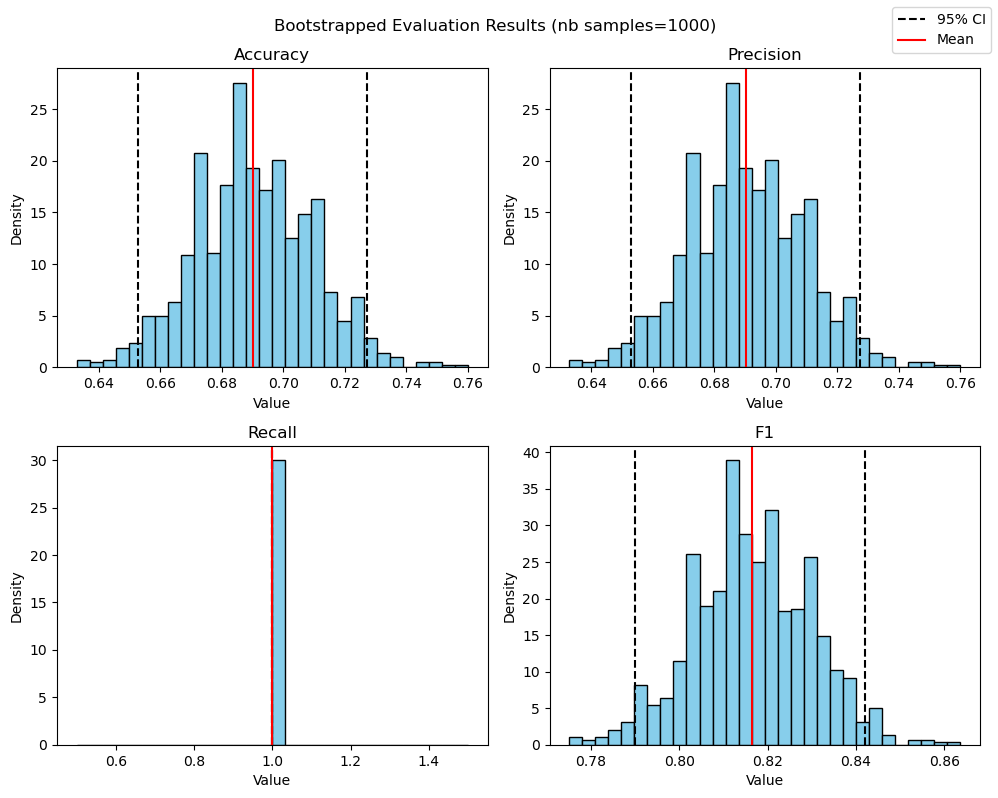

In [7]:
print("Mistral7B")
scorer_mistral7b = scorer_factory(scorer_type="binary", data=data, results=results_mistral7b)
scorer_mistral7b.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

Mixtral8x7B


Bootstrapping: 100%|██████████| 1000/1000 [00:07<00:00, 133.27it/s]


accuracy: 0.8077 (0.7727-0.84 95% CI)
precision: 0.8545 (0.8182-0.8895 95% CI)
recall: 0.8701 (0.836-0.9019 95% CI)
f1: 0.8621 (0.834-0.8866 95% CI)


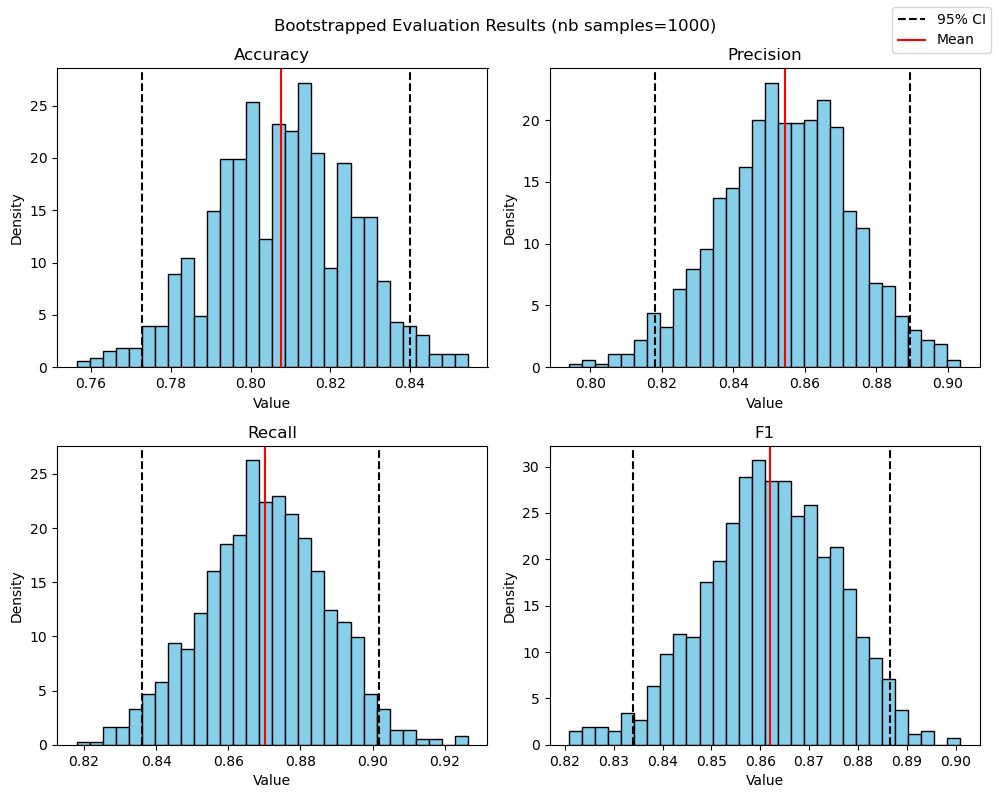

In [8]:
print("Mixtral8x7B")
scorer_mixtral8x7b = scorer_factory(scorer_type="binary", data=data, results=results_mixtral8x7b)
scorer_mixtral8x7b.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

Bootstrapping: 100%|██████████| 1000/1000 [00:08<00:00, 121.91it/s]


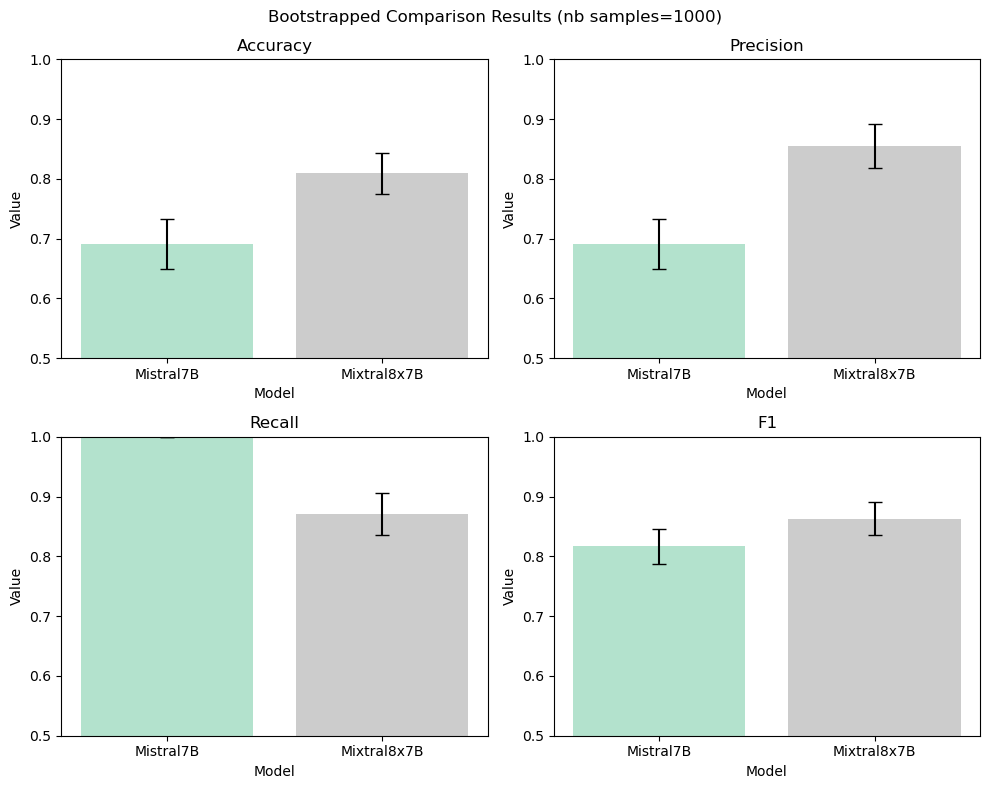

In [9]:
dict_scorers = {"Mistral7B": scorer_mistral7b, "Mixtral8x7B": scorer_mixtral8x7b}
compare_models_bootstrap(dict_scorers=dict_scorers, sample_size=len(data), n_samples=1000)

## Error Interrogation

In [10]:
df_mistral7b_error = scorer_mistral7b.get_error_dataframe()
df_mistral8x7b_error = scorer_mixtral8x7b.get_error_dataframe()

In [11]:
selected_columns = df_mistral7b_error.columns[:df_mistral7b_error.columns.get_loc("Target binary")+2].to_list() + ["Pred status"]
df_mistral7b_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target binary,symptom_detail_gs,Pred status
count,170,83,4,170,170,7,170,11,11,10,170,0,170
unique,170,2,3,50,2,1,50,3,1,2,1,0,1
top,"P: Uhm, I know my grandfather had lung cancer,...",Negative,Other,MSK0033.txt,Negative,Other,MSK0033.txt,None;Other,NONE,Negative;Positive,False,NaN,True
freq,1,80,2,7,163,7,7,9,11,7,170,NaN,170


In [12]:
with pd.option_context('display.max_colwidth', None):
    print(df_mistral7b_error["Context"].head())

7                                                                                                                                                                                                                                                                                     P: Uhm, I know my grandfather had lung cancer, but he used to smoke.\n\nD: OK, I see. How old was he? Roughly?\n\nP: Uhm, he was in his late 60s.\n\nD: OK, I'm sorry to hear that, and thank you and oh sorry, I forgot to ask her are you currently sexually active?\n\nP: No.\n\nD: OK. Have you been sexually active before?\n\nP: Uh, no. \n\nD: OK, so umm, OK. Uhm, so that was all the questions that, uhm that, that I wanted to ask, was there anything else that you wanted to umm, mention today?
10                                                                                                                                                                                                                                  

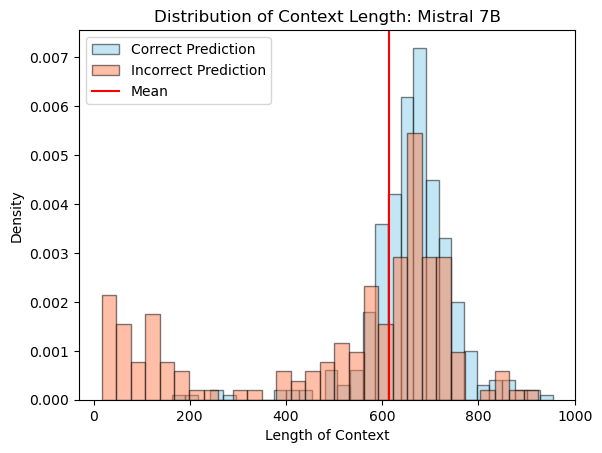

In [13]:
scorer_mistral7b.display_length_distribution("Mistral 7B")

note: there doesn't seem to be anything linked to the source given freq. Looking at the discussions, there are many instances where the patient mentions a symptom for a relative, but that doesn't apply to them. This is probably what the model catches on.

Interesting recall of 1

No NaNs

In [14]:
selected_columns = df_mistral8x7b_error.columns[:df_mistral8x7b_error.columns.get_loc("Target binary")+2].to_list() + ["Pred status"]
df_mistral8x7b_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target binary,symptom_detail_gs,Pred status
count,105,52,28,105,105,50,105,22,22,11,105,49,105
unique,105,2,20,48,2,31,48,11,12,2,2,31,2
top,D: Have you had any abdominal pain?\n\nP: No. ...,Positive,Other,RES0168.txt,Negative,Other,RES0168.txt,None;Other,NONE,Negative;Positive,False,other,True
freq,1,27,7,5,55,15,5,7,7,6,56,11,56


In [15]:
with pd.option_context('display.max_colwidth', None):
    print(df_mistral8x7b_error["Context"].head())

3                                                                    D: Have you had any abdominal pain?\n\nP: No. \n\nD: You had any diarrhea or, or constipation?\n\nP: Uh, no. \n\nD: OK. How about any urinary problems?\n\nP: Um, no, nothing like that. \n\nD: I see, OK. And any skin changes or rashes? \n\nP: No.\n\nD: Alright, any muscle aches or body pains?\n\nP: No. \n\nD: And any, and how's your energy been? Have you had fatigue?\n\nP: I have been, yeah, I've been tired.\n\nD: OK. And have you had any, have you been diagnosed with any medical conditions in the past?\n\nP: Um, I have type one diabetes. \n\nD: OK, and uh, insulin wise, do you use a pump or is it like, how do you manage diabetes?
4       P: I use an insulin pump, yeah.\n\nD: OK, excellent, and do you see an endocrinologist for that?\n\nP: I do.\n\nD: OK. Well that's good and have you had any complications or have things been stable?\n\nP: Things have been pretty stable. I had, when I was younger, I had a few episodes 

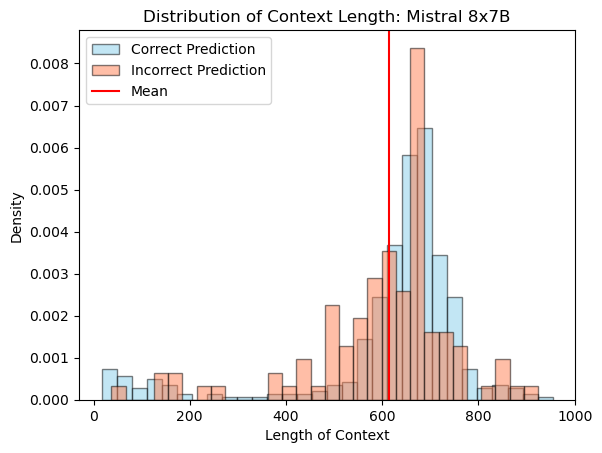

In [16]:
scorer_mixtral8x7b.display_length_distribution("Mistral 8x7B")